# Combining Pipe3D Data with Galaxy Zoo 3D masks

### A tutorial made by Maša (Masha) Kilibarda, Haverford '26, using original code and edits by Professor Karen Masters

This tutorial will help you combine different MaNGA value added catalogs (VACs) using Marvin. While the example given here is using Pipe3D stellar mass density, you can apply the presented method to any data you wish, provided you know it's structured in a similar way.

First, let's import some useful libraries. Please run the cell below without modifying it. If you want the warnings to disappear, just run the cell twice.

In [2]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as sci
plt.ion()

from marvin.tools.vacs import VACs
from astropy.io import fits
import numpy as np
from marvin.tools import Maps
from marvin.tools import Cube

from marvin import config #Needed to fix "Cube not subscriptable" when running in Sciserver
config.forceDbOff() #Needed to fix "Cube not subscriptable" when running in Sciserver

print('Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned')

Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned


In [3]:
#makes your plots look nicer, can play around with it if you want and see what each individual command does

style = {
    'lines.linewidth': 1.5,
    'font.size': 16.0,
    'axes.linewidth': 1.5,
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'legend.fancybox': True,
    'legend.fontsize': 'small',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',
    'figure.titlesize': 'large',
}

plt.style.use(style)

## One Galaxy Example

First, let's look at a possible way to apply our method on one singular galaxy. To do this, you will need to find a spiral galaxy (try playing with Marvin Web and finding a few examples!). You may also use the example I provided. If you wish to use your own example galaxy, follow the instructions outlined in the comments (text after the # symbol).

In [4]:
pipe3d = 'https://data.sdss.org/sas/dr17/manga/spectro/pipe3d/v3_1_1/3.1.1/8263/manga-8263-12705.Pipe3D.cube.fits.gz'

#to get a pipe3D fits file for a specific galaxy change the number after 3.1.1/ to the MaNGA plate number 
#(first 4 digits of MANGA plate-ifu) and the numbers after /manga- with the full plate-ifu value

hdu=fits.open(pipe3d) #opens your desired Pipe3D fits file

mass=hdu[1].data[19] 
#if you wish to use other Pipe3D data change the number 19 in this line with an appropriate number as listed in
#the Pipe3D cube specific catalog data model

mask=hdu[8].data
gaia=hdu[7].data
#these lines of code later used to remove low quality pixels, do not change

mangaid = '8263-12705' #MaNGA plate-ifu of the galaxy, can also use MANGA ID

maps = marvin.tools.Maps(mangaid)
data = maps.vacs.gz3d
#importing the GZ3D masks for this galaxy

Now that we imported our data, let's plot some fun Galaxy Zoo 3D images using Marvin and see what our galaxy looks like!

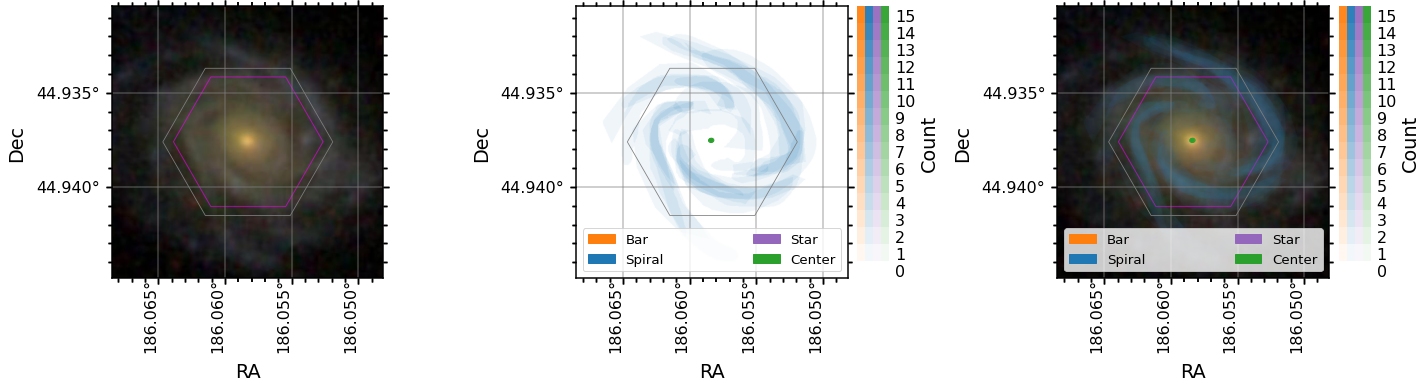

In [5]:
#Setting up the plot
plt.figure(figsize=(23, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.5)
ax0 = plt.subplot(gs[0], projection=data.wcs)

#Plot the orignal image shown to GZ3D volunteers
data.plot_image(color_grid='grey', ax=ax0)

#Plot a heat map showing vote counts for the four different tasks in GZ3D. We call these feature masks. 
data.plot_masks(color_grid='grey', subplot_spec=gs[1]);

#As above, but overlay on the image
data.plot_masks(show_image=True, color_grid='grey', subplot_spec=gs[2]);

Now let's try plotting Pipe3D data.

Text(0.5, 1.0, 'Pipe3D Stellar Mass Density')

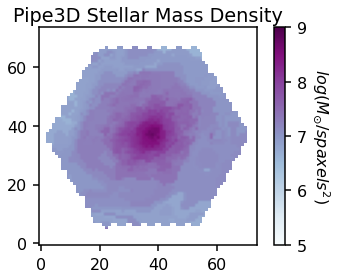

In [6]:
#These two lines create a mask to remove pixels with data quality flags. Try and understand how that works before moving on!
m=mass*mask
mask_m=np.where(m==0,np.nan,m)

#The following lines construct our plot
ax = plt.subplot()
plt.imshow(mask_m,cmap='BuPu',vmax=9,vmin=5) #vmax and vmin set the colorbar range so you might have to modify them to fit your data
ax.set_ylim(*ax.get_ylim()[::-1]) #needed to flip the axis for plots constructed from scratch, Marvin does this automatically
cb=plt.colorbar(location='right')
cb.set_label('$log(M_{\odot}/spaxels^2)$',labelpad=25,loc='center',rotation=270,size='medium')
ax.set_title('Pipe3D Stellar Mass Density')

In our plot, different colors correspond to different stellar mass density values, as outlined on the color bar. Once you are certain that you understand the scientific method and the code behind it, feel free to experiment and change how your plots look (you can change the colors, adjust the ticks and color bars etc.)! 

Our next step is to overlay a Galaxy Zoo 3D (GZ3D) mask on top of our Pipe3D data. You may have noticed in our first GZ3D example that Marvin has an automatic plotting function that simplifies the plotting process. You may have also noticed that I did not use that function to plot the Pipe3D data. The reason behind this decision is that, although Pipe3D is a value added catalog in Marvin, it does not have the same automatic plotting option that GZ3D does. The situation gets even more complicated once the two are combined. 

For this reason, our analysis needs to rely on constructing our own functions, rather than relying on the pre-made ones. This is a great coding exercise, so please try and understand each bit of the code before moving onto the next one.

It's time to combine GZ3D and Pipe3D data! First, let's overlay a spiral arm mask onto our stellar mass density data. Quick note: You can do this for any GZ3D mask available, or all of them combined! For further help on this, consult the GZ3D plotting tutorial.

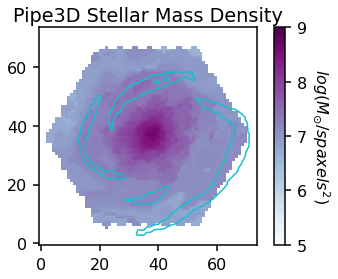

In [7]:
ax = plt.subplot()
plt.imshow(mask_m,cmap='BuPu',vmax=9,vmin=5)
ax.set_ylim(*ax.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label('$log(M_{\odot}/spaxels^2)$',labelpad=25,loc='center',rotation=270,size='medium')
ax.set_title('Pipe3D Stellar Mass Density')

#Notice that only one line of code was added in comparison to the Pipe3D only plot.
ax.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='C9')

In [8]:
#Pipe3D has some pixels flagged as having foreground stars. Let's remove those before we start our analysis!

indexes0=np.array([])
indexes1=np.array([])
for i in range(len(gaia)):
    for j in range(len(gaia[i])):
        if gaia[i][j]==1:
            indexes0=np.append(indexes0,i)
            indexes1=np.append(indexes1,j)
#a loop to extract the location of pixels to be removed

if len(indexes0)!=0:
    for i in indexes0:
        for i in indexes1:
            mask_m[int(i)][int(j)]=np.nan
#a mask to cover these pixels

All MaNGA data is divided into pixel bins and stored in 2-dimensional arrays. The first dimension (index) corresponds to the bin number, while the second dimension stores data for each pixel. You can try and understand this structure better by printing a few
bins or getting the length of different bins in the empty code box below. It is extremely important to get familiar and comfortable 
with how data you are working with is organized!

In [ ]:
#Place for your code here!

Let's start with our analysis! First, we need to separate pixels that belong to the spiral arm from the interarm pixels. This is the core of our method, so pay extra attention! It might also be useful to try and deconstruct some parts of the code to see how they work. I'll leave an empty code box for you to do this, should you wish to.

In [9]:
#Getting GZ3D spiral mask data
galaxy = data.spiral_mask_spaxel

#getting the values for stellar mass of arm vs interarm spaxels
max_a=np.max(galaxy) #find the spaxel with the max number of votes

inter=max_a*0.2 #set interarm threshold to 20% of this value (can change this threshold if you wish)
ar=max_a*0.6 #set arm threshold to 60% of this value (can change this threshold if you wish)

arm = np.where(galaxy > ar,1,np.nan)
interarm = np.where(galaxy < inter,1,np.nan)

#create masks for both arm and interarm spaxels
ma = mask_m*arm
mi = mask_m*interarm

In [ ]:
#Place for yoyr code here!

Let's try plotting the arm and interarm pixels we selected to see what they look like!

Text(0.5, 1.0, 'Pipe3D Stellar Mass Density')

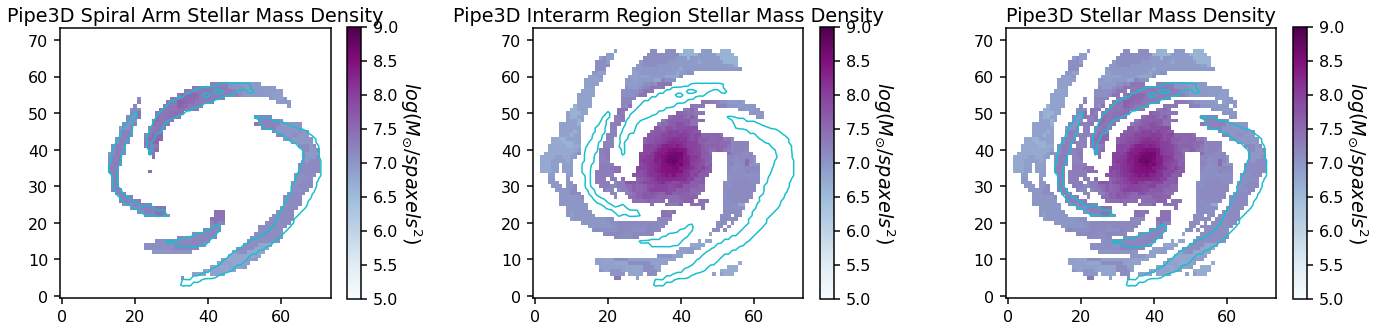

In [10]:
#Similar plotting as in the beginning. Try and spot what's different! Hints given throughout the code as *
#Setting up the Multiplot
fig,axs = plt.subplots(1, 3, figsize=(23, 5))
gs = gridspec.GridSpec(1, 3, fig, wspace=0.4)

#Spiral arm stellar mass plot
ax0 = plt.subplot(gs[0])
plt.imshow(ma, vmin=5, vmax=9,cmap='BuPu') #*
ax0.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='C9')
ax0.set_ylim(*ax0.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label('$log(M_{\odot}/spaxels^2)$',labelpad=25,loc='center',rotation=270,size='large')
ax0.set_title('Pipe3D Spiral Arm Stellar Mass Density',size='large')

#Interarm region 
ax1 = plt.subplot(gs[1])
plt.imshow(mi, vmin=5, vmax=9,cmap='BuPu') #*
ax1.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='C9')
ax1.set_ylim(*ax1.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label('$log(M_{\odot}/spaxels^2)$',labelpad=25,loc='center',rotation=270,size='large')
ax1.set_title('Pipe3D Interarm Region Stellar Mass Density',size='large')

#Combined plot
ax2 = plt.subplot(gs[2])
ax2.imshow(mi,vmin=5, vmax=9,cmap='BuPu') #*
ax2.imshow(ma,vmin=5, vmax=9,cmap='BuPu') #*
ax2.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='C9')
ax2.set_ylim(*ax2.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label('$log(M_{\odot}/spaxels^2)$',labelpad=25,loc='center',rotation=270,size='large')
ax2.set_title('Pipe3D Stellar Mass Density',size='large')

Although you can see there's a slight mass difference in the plots above, it might be difficult for you to make a precise comparison between the different stellar mass densities. Let's try averaging a certain number of arm and interarm stellar mass density values at the same galactic radius and connecting them with a line. To do this, we'll use the SciPy binned statistics functions, but there's many other ways to do it!

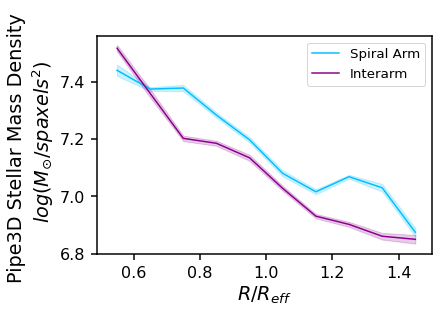

In [11]:
#stellar mass binned averages vs radius
radius = maps.spx_ellcoo_r_re #getting a radius value

mask=np.where(np.isnan(ma),0,1) #mask to cover all pixels that are not in the spiral arm
mask2=np.where(np.isnan(mi),0,1) #mask to cover all pixels that are not in the interarm region

bins=10
drange=[0.5,1.5]
#you can (and probably should!) change these values based on the data you're using

mass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange)
mass_mi,radius_mi,binnnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=bins,range=drange)
#binned mass averages - make sure you understand how this part works!!!

count_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='count')
sigmass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='std')
count_mi,radius_mi,binnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=bins,range=drange,statistic='count')
sigmass_mi,radius_mi,binnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=bins,range=drange,statistic='std')
#some statistics needed to compute error bars for the plot - std=standard deviation and count is just number of points in each bin

delta = (radius_ma[1]-radius_ma[0])/2.0 #to put plot points in middle of bin

plt.fill_between(radius_ma[:-1]+delta,mass_ma-(sigmass_ma/np.sqrt(count_ma)),mass_ma+(sigmass_ma/np.sqrt(count_ma)),color='deepskyblue',alpha=0.2)
plt.fill_between(radius_mi[:-1]+delta,mass_mi-(sigmass_mi/np.sqrt(count_mi)),mass_mi+(sigmass_mi/np.sqrt(count_mi)),color='darkmagenta',alpha=0.2)
#these two lines plot the error bars (i.e. the possible values range)

plt.xlabel(r'$ R/R_{eff} $')
plt.ylabel('Pipe3D Stellar Mass Density \n $log(M_{\odot}/spaxels^2)$')
plt.ylim(6.8,7.56)
plt.xlim(0.49,1.5)
plt.plot(radius_ma[:-1]+delta, mass_ma,label='Spiral Arm',c='deepskyblue')
plt.plot(radius_mi[:-1]+delta,mass_mi,label='Interarm',c='darkmagenta')
plt.legend()

You probably noticed that on average there is some excess in the spiral arm stellar mass density. But what is this value on average? Let's find out!

In [12]:
#calculating the fractional excess value
f=((10**(mass_ma))-(10**(mass_mi)))/(10**(mass_mi))
#remember that 10**logx=x

#error on the fractional excess
err_ma = sigmass_ma #std, and this is the error on log of value, hence the same as the fractional error on the value. 
err_mi = sigmass_mi
err_f = f*np.sqrt(err_ma**2 + 2*err_mi**2) # err_mi is twice becauses it's in the denominator

Text(0, 0.5, 'Fractional Excess of \n $log(M_{\\odot}/spaxels^2)$')

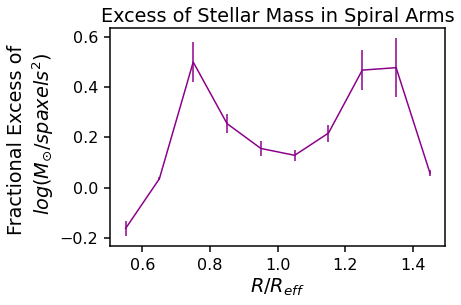

In [13]:
plt.errorbar(radius_ma[:-1]+delta,f,yerr=err_f,c='darkmagenta') #adds error bars
plt.title('Excess of Stellar Mass in Spiral Arms')
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Fractional Excess of \n $log(M_{\odot}/spaxels^2)$')

## Multiple Galaxies Example

Now that you've learned how to perform this analysis for one galaxy, let's see how to do the same thing for multiple galaxies at a time! The procedure will look very similar, but we will make use of a function that allows us to input different variables (i.e. MaNGA plate-ifus for different galaxies).

In [14]:
#a list of galaxies - you can add, subtract and change galaxies as you wish
mangaplifu=['8321-12705','8322-12704','8263-12705']

In [15]:
#a function to get appropriate values for arm vs interarm spaxels
def arm_selector (mangaplifu,at=0.6,it=0.2,bins=25,drange=[0,3.0]):
    plate = mangaplifu.split('-')[0]
    ifu = mangaplifu.split('-')[1]
    
    pi3D = 'https://data.sdss.org/sas/dr17/manga/spectro/pipe3d/v3_1_1/3.1.1/'+str(plate)+'/manga-'+str(plate)+'-'+str(ifu)+'.Pipe3D.cube.fits.gz'
    #Getting the FITS files for Pipe3D
    hdu1 = fits.open(pi3D)
    mass = hdu1[1].data[19]
    error=hdu[1].data[20]
    mask=hdu[8].data
    gaia=hdu[7].data
    
    #Getting the GZ3D files
    maps = marvin.tools.Maps(mangaplifu,mode='remote')
    data = maps.vacs.gz3d
    
    #removing bad spaxels
    m=mass*mask
    mask_m=np.where(m==0,np.nan,m)
    
    #removing spaxels with foreground stars
    indexes0=np.array([])
    indexes1=np.array([])
    for i in range(len(gaia)):
        for j in range(len(gaia[i])):
            if gaia[i][j]==1:
                indexes0=np.append(indexes0,i)
                indexes1=np.append(indexes1,j)
    if len(indexes0)!=0:
        for i in indexes0:
            for i in indexes1:
                mask_m[i][j]=np.nan
    
    #selecting arm vs interarm spaxels
    galaxy = data.spiral_mask_spaxel
    arm = np.where(galaxy > at,1,np.nan)
    interarm = np.where(galaxy < it,1,np.nan)
    ma = mask_m*arm
    mi= mask_m*interarm

    #getting binned averages
    radius = maps.spx_ellcoo_r_re
    mask=np.where(np.isnan(ma),0,1)
    mask2=np.where(np.isnan(mi),0,1)
    sigmass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='std')
    count_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='count')
    mass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='mean')
    mass_mi,radius_mi,binnnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=bins,range=drange,statistic='mean')
    sigmass_mi,radius_mi,binnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=bins,range=drange,statistic='std')
    count_mi,radius_mi,binnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=bins,range=drange,statistic='count')
    
    hdu1.close()
    
    return mass_ma,radius_ma,mass_mi,radius_mi,sigmass_ma,sigmass_mi,count_ma,count_mi

In [16]:
#Calculate excess in mass
def massexcess(mass_ma, mass_mi, sigmass_ma, sigmass_mi):
    
    f=((10**(mass_ma))-(10**(mass_mi)))/(10**(mass_mi))
    
    err_ma = sigmass_ma #std, and this is the error on log of value, hence the same as the fractional error on the value. 
    err_mi = sigmass_mi
    err_f = f*np.sqrt(err_ma**2 + 2*err_mi**2) # err_mi is twice becauses it's in the denominator

    return f, err_f

In [42]:
#run the functions
rad=np.array([])
m_ma=np.array([])
m_mi=np.array([])
sigma_ma=np.array([])
sigma_mi=np.array([])
cnt_ma=np.array([])
cnt_mi=np.array([])
fs=np.array([])
errsf=np.array([])
for i in mangaplifu:
    mass_ma,radius_ma,mass_mi,radius_mi,sigmass_ma,sigmass_mi,count_ma,count_mi=arm_selector(i)
    f,err_f=massexcess(mass_ma, mass_mi, sigmass_ma, sigmass_mi)
    rad=np.append(rad,radius_ma[:-1])
    m_ma=np.append(m_ma,mass_ma)
    m_mi=np.append(m_mi,mass_mi)
    sigma_ma=np.append(sigma_ma,sigmass_ma)
    sigma_mi=np.append(sigma_mi,sigmass_mi)
    cnt_ma=np.append(cnt_ma,count_ma)
    cnt_mi=np.append(cnt_mi,count_mi)
    fs=np.append(fs,f)
    errsf=np.append(errsf,err_f)
    print("Successful:",i)

Successful: 8321-12705
Successful: 8322-12704
Successful: 8263-12705


Let's plot our data and see what the stellar mass density excess looks like for a set of galaxies!

In [51]:
#selecting good points for the line plot
radius=np.array([])
masses=np.array([])
delta = (rad[1]-rad[0])/2.0 #to put plot points in middle of bin

#removing NumPy NaN values so they don't break the code
for i in range(len(fs)):
    if i!=np.nan:
        masses=np.append(masses,fs[i])
        radius=np.append(radius,rad[i])
        
excess_mean,radius_mean,binnumber = sci.binned_statistic(radius,masses,bins=10,range=[0.5,1.5])
excess_err,radius_mean,binnumber = sci.binned_statistic(radius,masses,bins=10,range=[0.5,1.5],statistic='std')
excess_count,radius_mean,binnumber = sci.binned_statistic(radius,masses,bins=10,range=[0.5,1.5],statistic='count')

Text(0.5, 1.0, 'Excess of Stellar Mass in Spiral Arms')

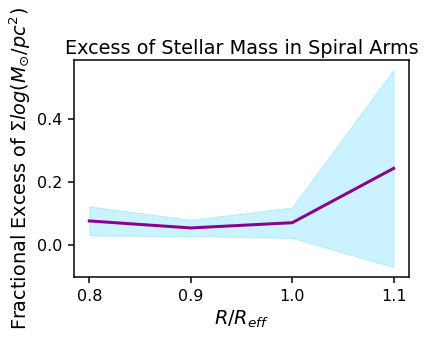

In [54]:
#excess mass average plot for the sample of galaxies as a function of radius

plt.plot(radius_mean[:-1], excess_mean,c='darkmagenta',linewidth=3)
plt.fill_between(radius_mean[:-1], excess_mean-(excess_err/np.sqrt(excess_count)),excess_mean+(excess_err/np.sqrt(excess_count)),alpha=0.2,color='deepskyblue')

plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Fractional Excess of $\Sigma log(M_{\odot}/pc^2)$')
plt.title('Excess of Stellar Mass in Spiral Arms')

Great! Now that you understand the basics of the method and the plotting, you are ready to start your own research. Good luck!